In [3]:
path = !kaggle datasets download -d "vijaykumar1799/face-mask-detection"

print("Path to dataset files:", path)

Path to dataset files: ["Warning: Looks like you're using an outdated API Version, please consider updating (server 1.7.4.2 / client 1.6.17)", 'Dataset URL: https://www.kaggle.com/datasets/vijaykumar1799/face-mask-detection', 'License(s): CC0-1.0', 'face-mask-detection.zip: Skipping, found more recently modified local copy (use --force to force download)']


In [13]:
import zipfile

dataset_path = "face-mask-detection.zip"  # Adjust this based on actual filename
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")  # Extract to "dataset" folder

print("Extracted files:", os.listdir("dataset"))


Extracted files: ['Dataset']


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2
import numpy as np


In [15]:
# Define paths
dataset_path = "C:/Users/aewad/dataset/Dataset"
output_dir = "C:/Users/aewad/dataset_split/"

# Define train, validation, and test split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create new folders for split dataset
for split in ["train", "val", "test"]:
    for category in ["with_mask", "without_mask"]:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Function to split and move files
def split_data(category):
    category_path = os.path.join(dataset_path, category)
    images = os.listdir(category_path)
    random.shuffle(images)

    train_files, temp_files = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    # Move files
    for file in train_files:
        shutil.move(os.path.join(category_path, file), os.path.join(output_dir, "train", category, file))
    for file in val_files:
        shutil.move(os.path.join(category_path, file), os.path.join(output_dir, "val", category, file))
    for file in test_files:
        shutil.move(os.path.join(category_path, file), os.path.join(output_dir, "test", category, file))

# Apply split to each category
for category in ["with_mask", "without_mask"]:
    split_data(category)

print("Dataset successfully split into train, val, and test sets!")


Dataset successfully split into train, val, and test sets!


In [17]:
# Define image size
IMG_SIZE = 224  # MobileNetV2 input size
BATCH_SIZE = 32

# Data augmentation for better model generalization
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation & test

# Load train and validation data
train_generator = train_datagen.flow_from_directory(
    'dataset_split/train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

val_generator = val_test_datagen.flow_from_directory(
    'dataset_split/val/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

test_generator = val_test_datagen.flow_from_directory(
    'dataset_split/test/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 4190 images belonging to 2 classes.
Found 898 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


In [27]:
# Load MobileNetV2 (pretrained on ImageNet)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze base model layers
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # 3 classes: Mask, No Mask, Incorrect Mask
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)


C:\Users\aewad\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 985ms/step - accuracy: 0.8800 - loss: 0.4052 - val_accuracy: 0.9477 - val_loss: 0.1395
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 121s 922ms/step - accuracy: 0.9531 - loss: 0.1317 - val_accuracy: 0.9655 - val_loss: 0.0933
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 121s 920ms/step - accuracy: 0.9621 - loss: 0.0955 - val_accuracy: 0.9621 - val_loss: 0.0984
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 122s 932ms/step - accuracy: 0.9600 - loss: 0.1067 - val_accuracy: 0.9800 - val_loss: 0.0572
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 119s 906ms/step - accuracy: 0.9760 - loss: 0.0682 - val_accuracy: 0.9722 - val_loss: 0.0679
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 118s 902ms/step - accuracy: 0.9707 - loss: 0.0739 - val_accuracy: 0.9610 - val_loss: 0.1019
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 118s 901ms/step - accuracy: 0.9766 - loss: 0.0638 - val_accuracy: 0.9811 - val_loss: 0.0600
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 120s 915ms/step - accuracy: 0.9743 -

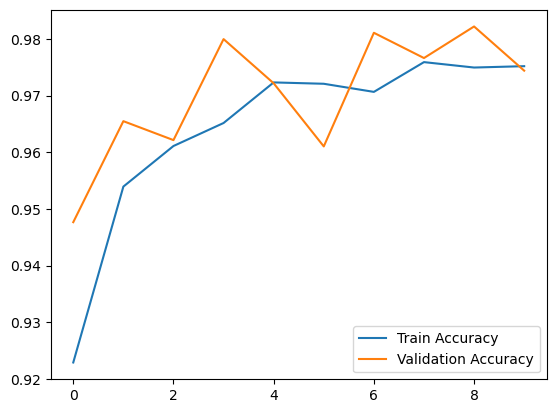

In [28]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [21]:
    # Evaluating the model
    val_loss, val_acc = model.evaluate(test_generator)
    print(val_loss)
    print(val_acc)

C:\Users\aewad\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 328ms/step - accuracy: 0.9855 - loss: 0.0483
0.044376589357852936
0.9855555295944214


In [29]:
model.save("mask_detector_model.keras")

In [18]:
# Load trained model
model = tf.keras.models.load_model("mask_detector_model.keras")

# Load face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Class labels
labels = ["With Mask", "Without Mask", "Mask Weared Incorrect"]

# Open webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
        face = np.expand_dims(face, axis=0) / 255.0

        # Predict mask
        prediction = model.predict(face)
        class_index = np.argmax(prediction)
        label = labels[class_index]

         # Choose color: Green (with mask), Red (without mask)
        if label == "With Mask":
            color = (0, 255, 0)
        elif label == "Without Mask":
            color = (0, 0, 255)

        # Draw bounding box and label
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    cv2.imshow("Face Mask Detector", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━

In [ ]:
|